In [23]:
import numpy as np
from tqdm import tqdm 
import torch
import numpy as np
import random
import itertools
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import sys
import os
os.chdir('d:\\xjr\\BPs_BPTK')
sys.path.append("Python") 
from BPS_init_function_MultiParas import BPS_BPTK_MultiParas
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei'] # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False # 用来正常显示负号
from sklearn.metrics import r2_score
import scipy.stats as stats


In [24]:
X =  np.load("Python\optim\Time_DualNN14\database\input_add.npy")  

y = np.load("Python\optim\Time_DualNN14\database\label_add.npy")  


def standard_transform(x):
    # 计算每个特征的均值
    mean = x.mean(dim=0)
    # 计算每个特征的标准差
    std = x.std(dim=0, unbiased=False)  # unbiased=False 相当于 numpy 的 ddof=0
    # 避免使用0的标准差
    std[std == 0] = 1
    # 进行标准化转换
    x = (x - mean) / std
    return x,mean,std

def standard_transform_paras(x,mean,std):
    
    x = (x - mean) / std
    return x


def inverse_transform(x, mean, std):
    # 将标准化后的张量乘以标准差，然后加上均值
    x = x * std + mean
    return x




X = torch.tensor(X).float()
y = torch.tensor(y).float()


X,X_mean,X_std = standard_transform(X)
y,y_mean,y_std = standard_transform(y)


X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.16, random_state=20)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=20)

X1 = np.load("Python\ForwardFitNN\WithTime\Database\ForwardInput_zzc.npy")
X2 = np.load("Python\ForwardFitNN\WithTime\Database\ForwardInput_SG.npy")
X_forward =  np.vstack((X1,X2))
X_forward  = torch.tensor(X_forward ).float()

_,X_forward_mean, X_forward_std = standard_transform(X_forward)
y1 = np.load("Python\ForwardFitNN\WithTime\Database\ForwardLabel_zzc.npy")  #输入标签数据
y2 = np.load("Python\ForwardFitNN\WithTime\Database\ForwardLabel_SG.npy")  #输入标签数据
y_forward = np.vstack((y1,y2))
y_forward  = torch.tensor(y_forward ).float()
_,y_forward_mean, y_forward_std = standard_transform(y_forward)


In [25]:
print(X_test[1,:])
print(y_test[1,:])

tensor([ 1.5308,  1.2677,  1.6725,  0.7378,  1.5381,  0.1997,  1.1436,  1.6175,
         1.6874,  1.1604,  1.4707,  1.5852,  1.6408,  1.6320,  1.6593,  1.2670,
         1.2723,  0.4348,  1.0656, -1.5624,  0.3749,  0.7110,  0.8800, -1.6122,
        -0.3397, -0.1500,  1.0460, -0.1691])
tensor([ 0.4117,  0.3617, -1.5326])


In [26]:
# 定义神经网络模型
class ResNetBlock(nn.Module):
    def __init__(self, hyperparas):
        super(ResNetBlock, self).__init__()
        
        self.hidden_dim = hyperparas['hidden_dim']
        self.block_layer_nums =hyperparas['block_layer_nums']
            
        # Define layers for the function f (MLP)
        self.layers = nn.ModuleList()
        
        for _ in range(self.block_layer_nums - 1):  # -2 because we already added one layer and last layer is already defined
            self.layers.append(nn.Linear(self.hidden_dim,self.hidden_dim ))
        
        # Layer normalization
        self.layernorms = nn.ModuleList()
        for _ in range(self.block_layer_nums - 1):  # -1 because layer normalization is not applied to the last layer
            self.layernorms.append(nn.LayerNorm(self.hidden_dim))
        
    def forward(self, x):
        # Forward pass through the function f (MLP)
        out = x
        for i in range(self.block_layer_nums - 1):  # -1 because last layer is already applied outside the loop
            out = self.layers[i](out)
            out = self.layernorms[i](out)
            out = torch.relu(out)
        
        # Element-wise addition of input x and output of function f(x)
        out = x + out
        
        return out
    

class CustomResNN(nn.Module):
    def __init__(self,hyperparas):
        super().__init__()
        self.input_dim = hyperparas['input_dim'] #68
        self.hidden_dim = hyperparas['hidden_dim'] #30
        self.hidden_nums = hyperparas['hidden_nums'] #3
        self.output_dim = hyperparas['output_dim'] #3
        self.block_layer_nums = hyperparas['block_layer_nums'] #3

        self.layer_list = []
        self.layer_list.append(nn.Sequential(nn.Linear(self.input_dim,self.hidden_dim),nn.ReLU() ) )

        for _ in range(self.hidden_nums-1):
            self.layer_list.append(ResNetBlock(hyperparas))

        self.layer_list.append(nn.Linear(self.hidden_dim,self.output_dim))

        self.linear_Res_final = nn.Sequential(*self.layer_list)

    def forward(self,inputs):
        
        return self.linear_Res_final(inputs)

#超参数合集
hyperparas_reverse = {'input_dim':28,'hidden_dim':40,'hidden_nums':4,'output_dim':3,'block_layer_nums':3}
hyperparas_forward_urine = {'input_dim':4,'hidden_dim':50,'hidden_nums':5,'output_dim':2,'block_layer_nums':3}
learning_rate = 0.001
num_epochs = 300

model_forward_urine = CustomResNN(hyperparas_forward_urine)
model_forward_urine.load_state_dict(torch.load('Python\\ForwardFitNN\\Settled_Model\\TimeFourTo2\\1\\model1.pth'))
bestmodel = CustomResNN(hyperparas_reverse)

In [27]:
#best_model_path ='Python\optim\Temporary_Model\model_pause1.pth'
#best_model_path ='Python\ForwardFitNN\Temporary_Model\model_pause2.pth'
#best_model_path ='Python\ForwardFitNN\Temporary_Model\model_pause3.pth'
best_model_path ='Python\\optim\\Settled_Model\\DualTime14\\model1.pth'


bestmodel.load_state_dict(torch.load(best_model_path))
# 准备数据

id = 0
time = np.arange(0,75,0.005)

In [8]:
#a = np.array([[16.2500,   8.8900,   5.5594]])

In [34]:
np.random.seed(0)
selected_indices = np.random.choice(X_test.shape[0], size=1800, replace=False)

a = y_test[selected_indices,:]

a = inverse_transform(a,y_mean,y_std)
a = a.detach().numpy()
label_final = a


In [35]:
_,urine_true,urineg_true =BPS_BPTK_MultiParas(t = time,volunteer_ID =id, paras = a,mode = '63')

100%|██████████| 1800/1800 [02:19<00:00, 12.94it/s]


In [36]:

input_final_transformed = X_test[selected_indices,:]
input_final = inverse_transform(input_final_transformed,X_mean,X_std)
    

In [11]:
#ForwardInput = torch.tensor([[[ 0.4117,  0.3617, -1.5326,  0.8013]]]).float()

In [37]:
draw_times = 1
drawnumber = 14

outputs = bestmodel(input_final_transformed )


outputs = inverse_transform(outputs, y_mean, y_std)
#print(outputs)

outputs = outputs.detach().numpy()
print(np.shape(outputs))

MSE = np.mean((label_final-outputs)**2)
print(f'三参数的MSE{MSE}')
MRE = np.mean((outputs/label_final)-1)
print(f'三参数的MRE{MRE}')



(1800, 3)
三参数的MSE0.21037393808364868
三参数的MRE0.0056702131405472755


In [38]:
_,urine_NN,urineg_NN =BPS_BPTK_MultiParas(t = time,volunteer_ID =id, paras = outputs ,mode = '63')

urine_NN_slice = np.zeros((np.shape(a)[0]*draw_times ,drawnumber))

urineg_NN_slice = np.zeros((np.shape(a)[0]*draw_times ,drawnumber))
urine_true_slice = np.zeros((np.shape(a)[0]*draw_times ,drawnumber))

urineg_true_slice = np.zeros((np.shape(a)[0]*draw_times ,drawnumber))
r2 =  np.zeros((np.shape(a)[0]*draw_times ,1))
if not isinstance(input_final, np.ndarray):
    input_final=input_final.detach().numpy()
for i in tqdm(range(np.shape(a)[0])):
    urine_NN_slice[i,:] = urine_NN[i,input_final[i,drawnumber:drawnumber*2].astype(int)]
    urineg_NN_slice[i,:] = urineg_NN[i,input_final[i,drawnumber:drawnumber*2].astype(int)]
    urine_true_slice[i,:] = urine_true[i,input_final[i,drawnumber:drawnumber*2].astype(int)]
    urineg_true_slice[i,:] = urineg_true[i,input_final[i,drawnumber:drawnumber*2].astype(int)]
  

100%|██████████| 1800/1800 [00:00<00:00, 99995.33it/s]


In [39]:
urinetotal_NN_slice = urine_NN_slice+urineg_NN_slice
urinetotal_true_slice = urine_true_slice+urineg_true_slice
MSE_concentration = np.mean((urinetotal_NN_slice-urinetotal_true_slice)**2)
print(f'含量信息的MSE{MSE_concentration}')
MRE_concentration = np.mean(abs(urinetotal_NN_slice-urinetotal_true_slice)/(urinetotal_true_slice+1E-15))
print(f'含量信息的MRE{MRE_concentration }')
for i in range(np.shape(a)[0]):
  r2[i] = r2_score( urinetotal_true_slice[i,:],urinetotal_NN_slice[i,:]) #决定系数

r2_mean = np.mean(r2)
print(f'含量信息的R2{r2_mean  }')

含量信息的MSE1.1596411928414802e-05
含量信息的MRE0.01068605151075155
含量信息的R20.9975019101777131


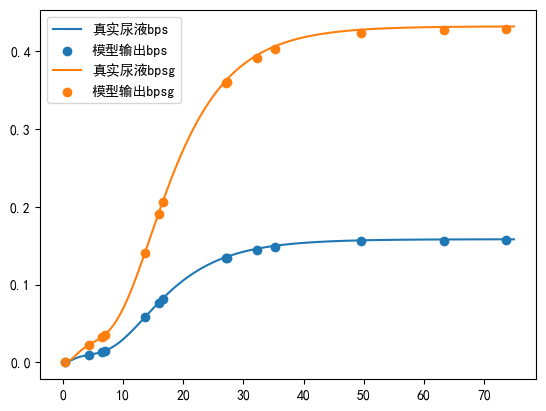

In [41]:
num =0

plt.plot(time,urine_true[num,], label='真实尿液bps')
plt.scatter(input_final[num,drawnumber:drawnumber*2].astype(int)/200, urine_NN_slice[num,:], label='模型输出bps')
plt.plot(time,urineg_true[num,], label='真实尿液bpsg')
plt.scatter(input_final[num,drawnumber:drawnumber*2].astype(int)/200, urineg_NN_slice[num,:], label='模型输出bpsg')

plt.legend()
plt.show()

[19.75     8.89     3.73125]


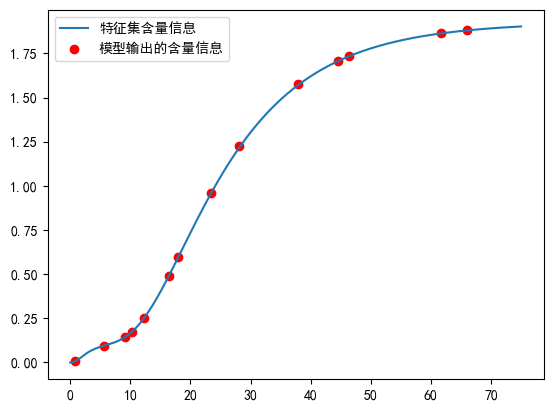

In [45]:
num =110
print(a[num,:])
plt.plot(time,urine_true[num,]+urineg_true[num,], label='特征集含量信息')
plt.scatter(input_final[num,drawnumber:drawnumber*2].astype(int)/200, urinetotal_NN_slice[num,:], label='模型输出的含量信息',c='red')


plt.legend()
plt.show()